# Milestone 2 pipeline

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive




## General scheme
The pipeline for Milestone 2 (and therefore M3 as well) is generally described by the following scheme:

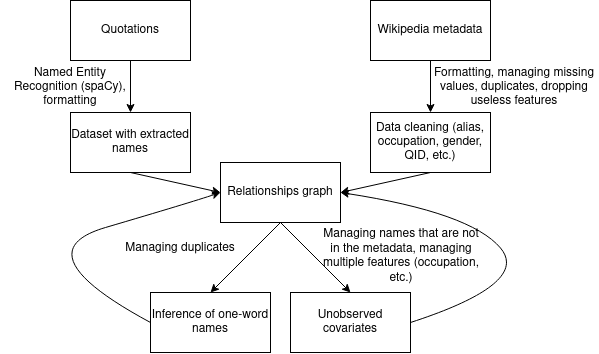

In [ ]:
from IPython.display import Image
Image('/content/drive/MyDrive/scheme.png')

## Meta Data extraction and cleaning
In this part, the meta data (features about the speakers, around 9M entries) is prepared to be joined with the names extracted from the quotations afterwards.

### Meta Data loading
We won't need to load all columns, as we mostly care about the **occupation** and **gender**. As this dataset isn't so large originally and we don't every load column, loading all of it at once is not an issue. However, the exploded views will contain a lot more entries, so we'll need to process those chunk per chunk.

In [ ]:
# loads the meta data
import bz2
import json
import pandas as pd

# it runs for ~2 mins
meta = pd.read_parquet('/content/drive/MyDrive/Project datasets/speaker_attributes.parquet',
                       columns=['aliases', 'label', 'occupation', 'gender'])
print(f"Loaded data about {meta.shape[0]} speakers")
meta.head()

Loaded data about 9055981 speakers


,aliases,label,occupation,gender
0,"[Washington, President Washington, G. Washingt...",George Washington,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ...",[Q6581097]
1,"[Douglas Noel Adams, Douglas Noël Adams, Dougl...",Douglas Adams,"[Q214917, Q28389, Q6625963, Q4853732, Q1884422...",[Q6581097]
2,"[Paul Marie Ghislain Otlet, Paul Marie Otlet]",Paul Otlet,"[Q36180, Q40348, Q182436, Q1265807, Q205375, Q...",[Q6581097]
3,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",George W. Bush,"[Q82955, Q15982858, Q18814623, Q1028181, Q1408...",[Q6581097]
4,"[Velázquez, Diego Rodríguez de Silva y Velázqu...",Diego Velázquez,[Q1028181],[Q6581097]


### Preprocessing the gender
At some point the dataset will be exploded according to the aliases, which will multiply the number of entries. Therefore, it is preferable to do as much preprocessing as possible before, including dealing with the gender.

#### What does the 'gender' feature look like ?

It must be noted that 'gender' is actually a list when it is not None. We can check the number of genders on average for each entry:

In [ ]:
def average_number_of_items(data, column):
  """
  Computes the average number of items in a column whose values are lists or
  None. Counts "None" as one value.
  """
  return data[column].apply(lambda x: len(x) if x is not None else 1).mean()

In [ ]:
average_number_of_items(meta, 'gender')

1.0001533792970634

It appears that 0.015% of the entries include multiple genders. Therefore those
rows will not induce a bias in the graph as the occupations could (see below).

We can have a look at how the genders are distributed in the population to know
how many nodes in the graph the 'genre' feature would induce:

In [ ]:
from collections import Counter

In [ ]:
def count_occurences(series):
  """
  Counts the occurences of each value in a pd series
  whose elements are lists.
  """
  # Counts the occurences of each item that is at least in one
  # list
  cnt = Counter()
  def add_to_counter(items):
    if items is None:
      cnt["None"] += 1
    else:
      for item in items:
        cnt[item] += 1
  series.apply(add_to_counter)

  # Returns the result as a dataframe sorted in descending order
  df = pd.DataFrame({"occurences": cnt.values()}, index=cnt.keys())
  return df.sort_values(by='occurences', ascending=False)

In [ ]:
gender_occurences = count_occurences(meta['gender'])
print(f'Found {gender_occurences.shape[0]} distinct genders')

Found 40 distinct genders


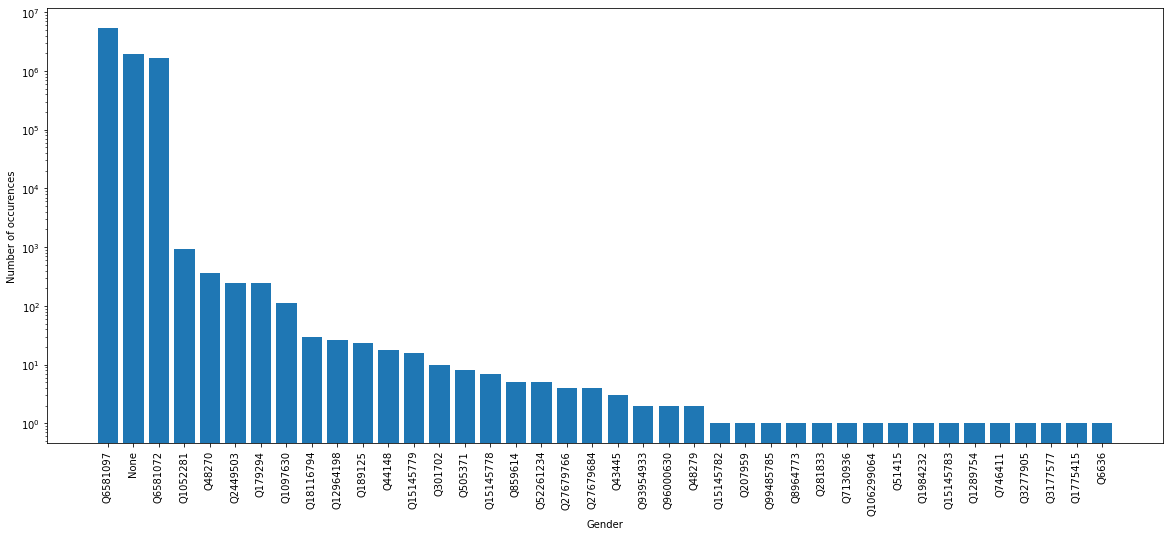

In [ ]:
# Plots the occurences of each gender
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
ax.set_xlabel("Gender")
ax.bar(np.arange(gender_occurences.shape[0]), gender_occurences['occurences'])
ax.set_ylabel("Number of occurences")
ax.set_yscale('log')
ax.set_xticks(np.arange(gender_occurences.shape[0]))
ax.set_xticklabels(gender_occurences.index, rotation=90)
fig.show()

Note that we don't need to know the names of the genders for now so we stick to the QIDs. The human-readable names will be retrieved later in the pipeline.

Conclusion: we found 40 distinct genders, which is *a priori* not too many to be used to split the people into groups. On the other hand, most of the genders only appear one, a few times or a few tens of times. As **we want to avoid very small groups** (such as one or two people), it will probably be better to **create a category for those extremely rare genres**.

### Preprocessing the occupation
Similarly to the gender, the occupation is actually a list of Wikidata entity ids. There are several ways we can go about it:
* 1 - Keep all occupations. This could generate a bias as a single person could generate links between multiple nodes in the graph when they are a speaker or are mentioned in a quotation. For example, if "Barack Obama" mentions a person P, this will create a link from all of B.Obama's occupations to P's occupation. This would include occupations one would not think of, such as "political writer" that are in fact nowhere related to the content of the quotation. However, we need to split the people in a way so that groups are not to small. If for example every person had a unique occupation, then we would find ourselves with a node in the graph for every person !

* 2 - Select a single occupation for each person. For example, the occupations on Wikipedia are sorted according to their importance / relevance (Barack Obama is reffered to as 'politician', then 'lawyer' before 'political writer'). It would therefore make sense to use only the first occupation. However this can also create a bias since some occupations could by nature not in general be a main occupation (which is the case of 'political writer'). Nonetheless if the first occupation is on average very specific and only includes a few individuals, then we *again* find ourselves with a too sharp splitting.

* 3- Selecting a set of occupations based on their repartition in the data. This would solve the problem of splitting the speakers into large groups, as we could keep for example only the 100 most represented occupations. However we loose the information regarding the least represented occupations, which could have be interesting for the analysis in the end. One way to solve this issue to is to select the most represented occupations and create an 'other' category, just like for the gender. This 'other' category could actually be several 'other' categories, in which the occupations are matched together by similarity.

* 4 - A mix of (1) and (3): we first build the graph with all occupations. Let's ignore the gender here for simplification. As each node corresponds to a single occupation, we obtain a graph with as many nodes as distinct occupations in the meta data. We then **group the graph nodes together based on their proximity**. Let G1, G2 be a pair of very small groups, then if G1 and G2 are linked or are linked to another large group, then G1 and G2 are merged into a new larger group. This method is more computationally expensive as we need to build the graph with all occupations, but lets us adjust the sizes of the nodes as we can merge groups together until they're large enough. The main downside is that we might merge groups that should remain separated (for example, 'pornographic actor' and 'researcher') if we're not careful.

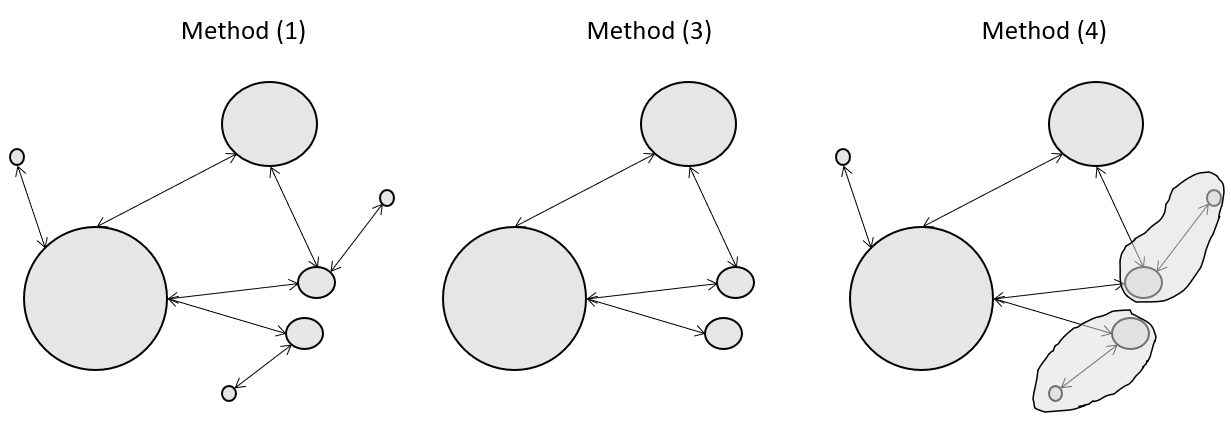

In [ ]:
Image('/content/drive/MyDrive/pictures/occupations_methods.PNG')


In order to get an idea of which method best suits our need, we need more details about the 'occupation' feature.
We can have a look at the distribution of the number of occupations per person:

In [ ]:
# Counts the number of occupations in each entry, counting None as 0
nb_occupations = meta['occupation'].apply(lambda x: len(x) if x is not None else 0)
nb_occupations.describe()

count    9.055981e+06
mean     9.209621e-01
std      8.756128e-01
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      3.300000e+01
Name: occupation, dtype: float64

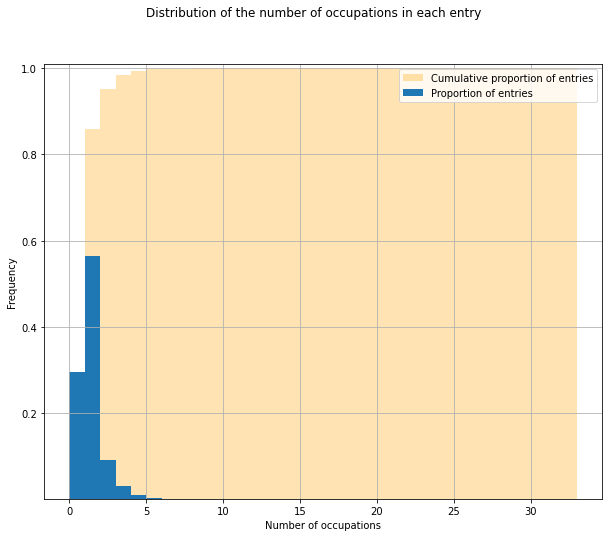

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
nb_occupations.hist(bins=33, ax=ax, cumulative=True, density=True,
                    color="orange", alpha=0.3)
nb_occupations.hist(bins=33, ax=ax, density=True)
ax.set_xlabel("Number of occupations")
ax.set_ylabel("Frequency")
ax.set_ylim([0.001, 1.01])
ax.legend(['Cumulative proportion of entries', 'Proportion of entries'],
          loc="upper right")
fig.suptitle("Distribution of the number of occupations in each entry")
fig.show()

We conclude that:
* On average the entries have less than 1 occupation (because of the ~$1.5* 10^6$ None values, which represent at least 25% of the dataset);
* About 55% of the entries have a single occupation, and about 15% have multiple occupations.
* Entries with more than 5 occupations are exceptional.

As mentioned, a crucial point is the distribution of the *number of occurences* of the occupations. We need to know how specific the occupations are: if each occupation only corresponds to 1 or 2 speakers then the feature cannot be used to group people, as it would create too many groups.

In [ ]:
# Counts the number of occurences of each occupation
occupations_count = count_occurences(meta['occupation'])

In [ ]:
print(f'Found {occupations_count.shape[0]} distinct occupations (ignoring None)')
occupations_count.head(10)

Found 14576 distinct occupations (ignoring None)


,occurences
None,2682897
Q1650915,1694140
Q82955,658049
Q937857,317958
Q33999,281266
Q36180,278888
Q1028181,169246
Q3665646,133601
Q1930187,128913
Q1622272,119861


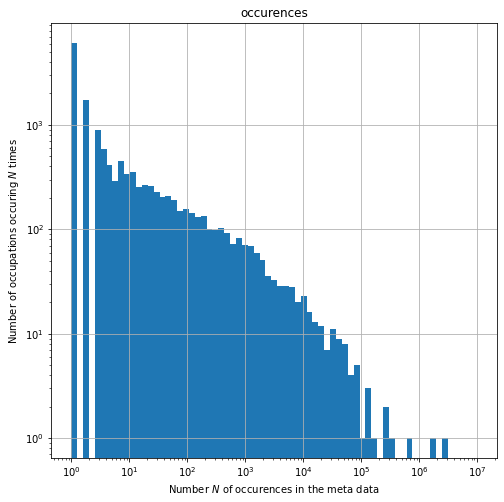

In [ ]:
# Plots the distribution of the number of occurences of the occupations
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
logbins = np.logspace(0, 7, 70)
occupations_count.hist(ax=ax, log=True, bins=logbins)
ax.set_xscale('log')
ax.set_xlabel("Number $N$ of occurences in the meta data")
ax.set_ylabel("Number of occupations occuring $N$ times")
fig.show()

The meta data contain 14 575 occupations for 9M entries if the entries with None occupations are ignored. While this still makes more than 600 people per occupation on average, we can't afford to create a graph with 14 000 nodes.

However it appears that a tiny proportion of the occupations includes those that appear the most in the meta data. This lets us think that method (3) can be suited to our objective. For instance, selecting only the occupations that appear at least 10 times yields less than a hundred occupations instead of 14 500 !

### Exploding according to the aliases
We'll use the aliases to match the names extracted from the quotations:

In [ ]:
meta = meta.explode('aliases')
meta.head()

,aliases,label,occupation,gender
0,Washington,George Washington,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ...",[Q6581097]
0,President Washington,George Washington,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ...",[Q6581097]
0,G. Washington,George Washington,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ...",[Q6581097]
0,Father of the United States,George Washington,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ...",[Q6581097]
0,The American Fabius,George Washington,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ...",[Q6581097]


## Referred names in quotations
In this part, we extract referred names from quotations with spaCy and we do some analysis on the obtained distribution.

### Name extraction with spaCy


In [ ]:
import csv
import bz2
import json
import en_core_web_sm
import pandas
import matplotlib.pyplot as plt
import itertools
import re
import random
import seaborn as sns
import numpy as np

from collections import Counter

We perform Named Entity Recognition using spaCy's library. We fix the size at 100 000 samples as it takes around 2 hours to generate it. Note that, as the size of Quotebank's datasets are large, we don't care about sampling with or without replacement, as variances for both are the same in average. CSV files generated are composed of 3 features: quoteID (id of the quotation), *subject* (referred person) and *speaker* (Quotebank's speakers).

In [ ]:
# Samples we extract
MAX_SAMPLES = 100000
STEP_PROGRESS = MAX_SAMPLES / 10

# https://spacy.io/models/en
nlp = en_core_web_sm.load()

def init_csv(output_filename):
  """
  Init CSV file with header
  subject is a new feature corresponding 
  to the referred person
  """
  header = ['quoteID', 'subject', 'speaker']
  with open(output_filename, 'w') as output_file:
    writer = csv.writer(output_file)
    writer.writerow(header)
        
def write_to_csv(output_filename, samples):
  """
  Write to CSV file samples which have been extracted
  """
  with open(output_filename, 'a') as output_file:
    writer = csv.writer(output_file)
    for sample in samples:
      writer.writerow(sample)
            
def construct_name_feature(filename, output_filename):
  """
  Parse Quotebank's dataset and extract names with spaCy
  Processing and writting to CSV file are done on the fly
  to avoid overloading the RAM memory
  """
  nb_samples = 0
  samples = []
  limit_progress = STEP_PROGRESS
  perc_progress = 10
  
  with bz2.open(filename, "rt") as file:

    # Browse each row in Quotebank's dataset
    for i, row in enumerate(file):
          
      # Write in the CSV file 10 000 samples retrieved
      # to avoid overloading the RAM memory
      if i % 10000 == 0:
        write_to_csv(output_filename, samples)
        samples = []

      # Tokenize a row with spaCy
      sample = json.loads(row)
      sample_tokens = nlp(sample['quotation'])
      for x in sample_tokens.ents:
        # None speakers are not considered in our problem
        if x.label_ == 'PERSON' and sample['speaker'] != 'None':
          samples.append(
            [sample['quoteID'], x.text, sample['speaker']]
          )
          nb_samples += 1
          
      # Progression of processing
      if (nb_samples >= limit_progress):
        print('{}% name couples have been obtained for {}.'.format(perc_progress, output_filename))
        limit_progress += STEP_PROGRESS
        perc_progress += 10
          
      # Exit condition
      if (nb_samples >= MAX_SAMPLES):
        break
              
    # Write the last obtained samples
    write_to_csv(output_filename, samples)

Let's generate our datasets with 100 000 samples for each year of Quotebank's datasets. The boolean below has to be settled to True if you want to generate them (note: you have time to watch the Lord of the Rings trilogy 😀).


In [ ]:
# The generation of a dataset for 100 000 samples is about 2 hours
# Set DO_EXTRACTION boolean to True if you want to generate them
DO_EXTRACTION = False

if (DO_EXTRACTION):

  # Quotebank's datasets
  filenames = ['/content/drive/MyDrive/Quotebank/quotes-2015.json.bz2', '/content/drive/MyDrive/Quotebank/quotes-2016.json.bz2', '/content/drive/MyDrive/Quotebank/quotes-2017.json.bz2',
                '/content/drive/MyDrive/Quotebank/quotes-2018.json.bz2', '/content/drive/MyDrive/Quotebank/quotes-2019.json.bz2', '/content/drive/MyDrive/Quotebank/quotes-2020.json.bz2']

  # CSV files with extracted names
  output_filenames = ['/content/drive/MyDrive/OwnData/quotes-2015-subjects.csv', '/content/drive/MyDrive/OwnData/quotes-2016-subjects.csv', '/content/drive/MyDrive/OwnData/quotes-2017-subjects.csv',
                      '/content/drive/MyDrive/OwnData/quotes-2018-subjects.csv', '/content/drive/MyDrive/OwnData/quotes-2019-subjects.csv', '/content/drive/MyDrive/OwnData/quotes-2020-subjects.csv']

  # Init CSV files
  for output_filename in output_filenames:
    init_csv(output_filename)
    print('File {} initialized.'.format(output_filename))

  # Extract names from Quotebank's datasets
  for filename, output_filename in zip(filenames, output_filenames):
    construct_name_feature(filename, output_filename)
    print('File {} processes.'.format(filename))

### Extracted names distribution

CSV files have been zipped post-generation. 

In [ ]:
years = ['2015', '2016', '2017', '2018', '2019', '2020']

zipped_filenames = ['/content/drive/MyDrive/OwnData/quotes-2015-subjects.csv.zip', '/content/drive/MyDrive/OwnData/quotes-2016-subjects.csv.zip', '/content/drive/MyDrive/OwnData/quotes-2017-subjects.csv.zip',
                    '/content/drive/MyDrive/OwnData/quotes-2018-subjects.csv.zip', '/content/drive/MyDrive/OwnData/quotes-2019-subjects.csv.zip', '/content/drive/MyDrive/OwnData/quotes-2020-subjects.csv.zip']

dfs = [pandas.read_csv(filename, compression='zip') for filename in zipped_filenames]
# It has been discovered that quotations can be duplicated in Quotebank's datasets, we remove them for now
# Datasets without duplicates will be generate again for Milestone 3
dfs = [df.drop_duplicates(subset=['quoteID'], keep='first', inplace=False) for df in dfs] 

In [ ]:
dfs[0].head(10)

,quoteID,subject,speaker
0,2015-06-18-018819,Donald Trump,Chris Matthews
1,2015-09-16-000331,Jason,Jordan Spieth
3,2015-10-25-000242,Clinton,Bernie Sanders
4,2015-04-25-012511,Howard,Rick Carlisle
5,2015-10-04-014109,Trafford,Michael Owen
6,2015-10-02-000466,Miller,Norv Turner
7,2015-07-14-000994,Steven Universe,Rebecca Sugar
9,2015-11-17-031545,Sanjay Dutt,Dawood Ibrahim
10,2015-03-04-024691,Kohli,Virat Kohli
11,2015-05-13-000039,Tommy,Vince Wilfork


In [ ]:
def get_possessive_names(df):
  """
  Get all names which end with possessive form
  Example: Adrien's ends with a possessive form
  """
  possessive_names = []
  for name in df['subject']:
    x = re.search("^[a-zA-Z ]+'s$", name)
    # We have found a possessive form
    if x is not None:
      possessive_names.append(name)
  return possessive_names

def get_bad_names(df):
  """
  Get all names which contain characters as parentheses,
  slashes, brackets, etc. They are not valid names
  """
  bad_names = []
  for name in df['subject']:
    x = re.search("^[a-zA-Z ]+['s]*", name)
    # We have found a bad name
    if x is None:
      bad_names.append(name)
  return bad_names

possessive_names_dfs = [get_possessive_names(df) for df in dfs]
bad_names_dfs = [get_bad_names(df) for df in dfs]

for i in range(len(years)):
  print('Year {}: [possessive_names={},bad_names={}]'.format(years[i], len(possessive_names_dfs[i]), len(bad_names_dfs[i])))

Year 2015: [possessive_names=1414,bad_names=315]
Year 2016: [possessive_names=1499,bad_names=400]
Year 2017: [possessive_names=1453,bad_names=427]
Year 2018: [possessive_names=1405,bad_names=417]
Year 2019: [possessive_names=1505,bad_names=503]
Year 2020: [possessive_names=1394,bad_names=547]


As we can see, the names ending with a possessive form, i.e., ending with the pattern *'s are rather present (about 1.5% of the whole dataset). These names can be kept by removing this pattern. Now, 0.05% of each dataset seems unusable as names contain unusual characters such as parentheses, brackets or slashes. As a result, we'll be able to remove all these characters to try to keep some names (note: these are spaCy mistakes).

In [ ]:
# Computes the number of words in each name, for each year, for subjects and speakers
sizes_names_subjects = [df['subject'].str.split().str.len().value_counts() for df in dfs]
sizes_names_speakers = [df['speaker'].str.split().str.len().value_counts() for df in dfs]

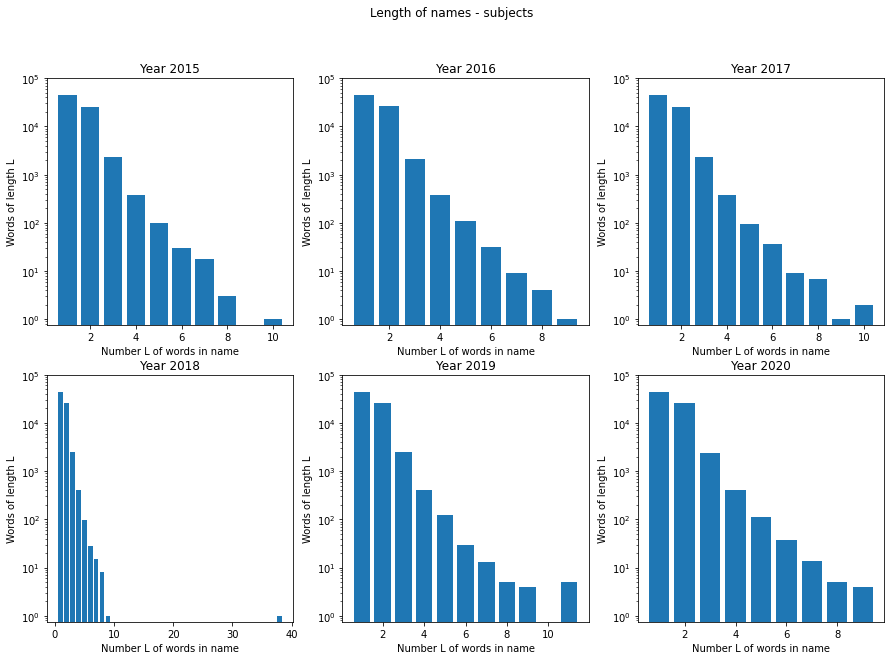

In [ ]:
def plot_sizes(sizes):
  fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
  for i, size in enumerate(sizes):
    ax = axes[i // 3, i % 3]
    ax.bar(size.index, size.values)
    ax.set_yscale('log')
    ax.set_ylabel("Words of length L")
    ax.set_xlabel("Number L of words in name")
    ax.set_title("Year {}".format(2015 + i))
    ax.set_ylim(0.75, 1e5)
  return fig

fig = plot_sizes(sizes_names_subjects)
fig.suptitle("Length of names - subjects")
fig.show()

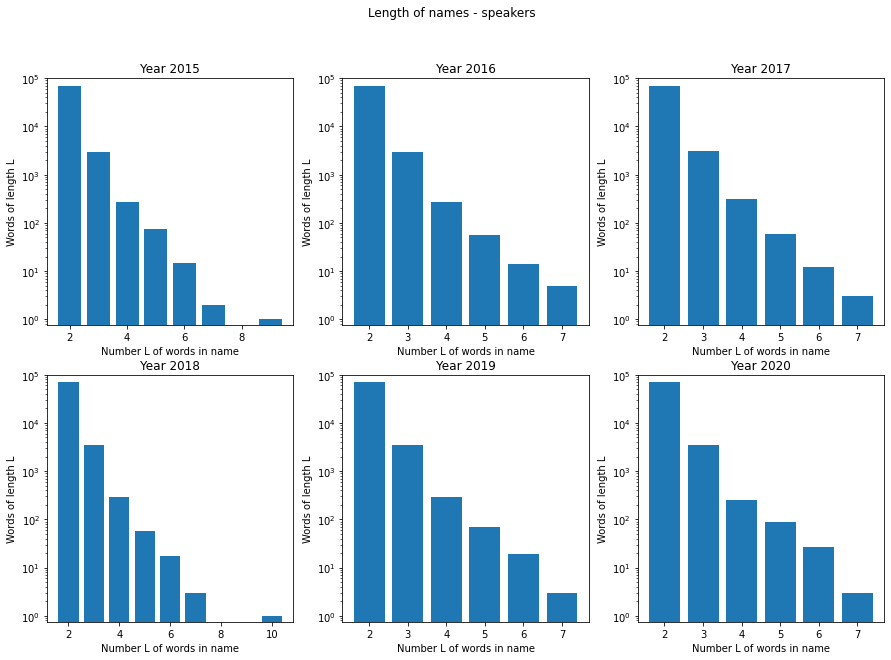

In [ ]:
fig = plot_sizes(sizes_names_speakers)
fig.suptitle("Length of names - speakers")
fig.show()

The bar charts above show the number of words for each name in each of our datasets (each year). We can see that for the majority of the extracted referred persons, all the names are composed of a single word (first or last name). This *can* be a problem that we should have to address. Otherwise, other names consist of two words. Also, distributions between each year are almost identical (note the year 2018 where the x-scale is off due to an outlier with a name with 40 words, this should be a spaCy error). For speakers, distributions are also equivalent and this time, we notice that all the names are mainly composed of two words. 

In [ ]:
def get_count_duplicates(df):
  """
  Group rows that are duplicated and count them
  """
  # Group rows of subject feature (extracted names)
  duplicates = df.loc[df['subject'].duplicated(keep=False)] \
                .groupby('subject') \
                .agg({'subject': 'count'}) \
                .rename(columns={'subject': 'subject_count'}) \
                .sort_values(by='subject_count', ascending=False) \
                .reset_index()

  return duplicates

# Contains the counts of each name that appears multiple times,
# for each year
duplicates_dfs = [get_count_duplicates(df) for df in dfs]

In [ ]:
def plot_recurrent_names(names_counts):
  fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20,13), tight_layout=True)
  for i, names_count in enumerate(names_counts):
    # Retrieves the name and the occurences count
    names = names_count.iloc[:20, 0]
    counts = names_count.iloc[:20, 1]

    ax = axes[i // 3, i % 3]
    ticks = np.arange(names.shape[0])
    ax.bar(ticks, counts)

    ax.set_xticks(ticks)
    ax.set_xticklabels(names, rotation=90)
    ax.set_ylabel("Number of mentions in quotations")
    ax.set_xlabel("Subject name")
    ax.set_title("Year {}".format(2015 + i))
    ax.set_ylim(0, 1650)
  return fig

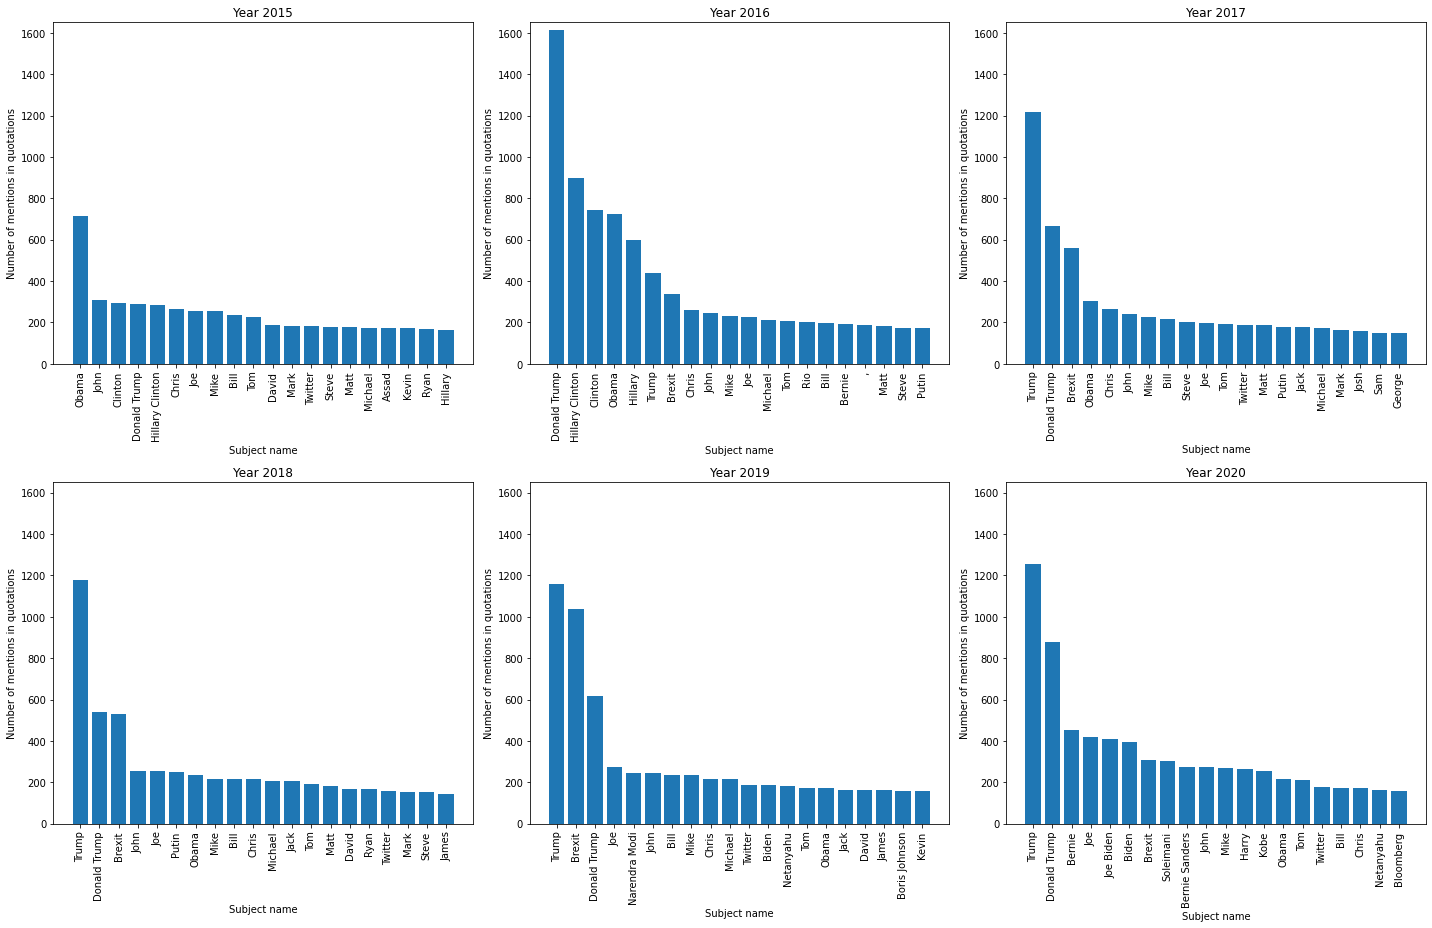

In [ ]:
fig = plot_recurrent_names(duplicates_dfs)
fig.show()

The above data represents the number of times a name appears in the extracted referred persons. It's pretty much distributed in the same way (always people from the political sphere in the lead), but there is... Brexit !? It seems to be a spaCy mistake which should not be a big problem for us because Brexit should not be present in the metadata, so it will be thrown away. Note that political figures often appear with one or two words in their names (as "Hillary", "Clinton" and "Hillary Clinton" in 2016).

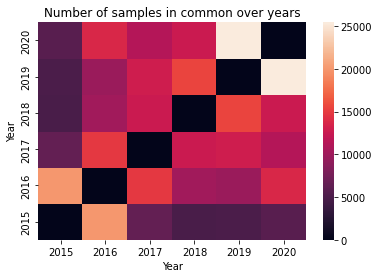

In [ ]:
# Get samples which are in common over years
commons_samples_sizes = np.array([[0 for _ in range(6)] for _ in range(6)])
for ((i_1, df_1), (i_2, df_2)) in itertools.combinations(enumerate(dfs), 2):
  # Store the number of samples in a matrix
  commons_samples_sizes[i_1, i_2] = len(df_1.merge(df_2, on=['subject', 'speaker'], how='inner').index)
  commons_samples_sizes[i_2, i_1] = commons_samples_sizes[i_1, i_2]

# Plot a heatmap (we force to 0 on the diagonal as years are identical)
ax = sns.heatmap(commons_samples_sizes, xticklabels=years, yticklabels=years)
ax.invert_yaxis()
plt.xlabel('Year')
plt.ylabel('Year')
plt.title('Number of samples in common over years')
plt.show()

The matrix above shows the number of pairs (subject, speaker) in common for each years pair. We can note that it is very interesting, because the distribution does not seem uniformly distributed, affirming our choice to work on the evolution of relationships over the years. In particular, we can see that the number of couples in common is greatest for two consecutive years, which seems reasonable as people are more likely to be in short-term relationships. Another reason could be that many people have relationships at the end of the year and the beginning of the next year. Perhaps, it should be more interesting to reason in terms of months rather than years to be more precise.

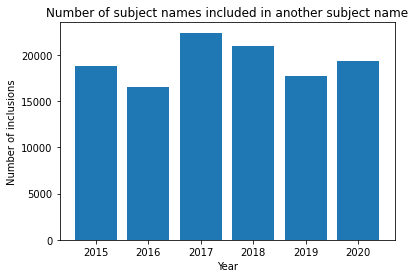

In [ ]:
def is_included(name_1, name_2):
    """
    Returns true if name_1 is included in name_2
    """
    return name_1 in name_2

def construct_included_names(names_1, names_2):
  """
  Check for each x in names_1 (resp. names_2) 
  if x is included in names_2 (resp. names_1)
  """
  included_names = []
  
  for first_name, second_name in itertools.product(names_1, names_2):
    # If name sizes are not the same, we don't consider it
    if len(first_name) != len(second_name) and is_included(first_name, second_name) or is_included(second_name, first_name):
      
      string_first_name = ' '.join(first_name)
      string_second_name = ' '.join(second_name)
      included_names.append((string_first_name, string_second_name))
              
  # We only want to know the unique pairs
  included_names = set(included_names)
  return (len(included_names), included_names)

# Generate 10 000 samples from extracted names distribution
# Note: we reduce the problem because of combinatorial explosion
nb_rows = 100000
sample_size = 10000

reduced_dfs = []
for i, filename in enumerate(zipped_filenames):
    # Get a permutation
    skip = sorted(random.sample(range(1, nb_rows + 1), nb_rows - sample_size))
    # Read CSV files and skip rows that are not in the permutation
    reduced_df = pandas.read_csv(filename, skiprows=skip, compression='zip')
    # Drop duplicates
    reduced_df.drop_duplicates(subset=['quoteID'], keep='first', inplace=True)
    reduced_dfs.append(reduced_df)

# Get included names for each year
included_names_dfs = [construct_included_names(reduced_df['subject'].tolist(), reduced_df['subject'].tolist()) for reduced_df in reduced_dfs]

# Plot a bar chart
plt.bar(years, [x[0] for x in included_names_dfs])
plt.xlabel("Year")
plt.ylabel("Number of inclusions")
plt.title("Number of subject names included in another subject name")
plt.show()

The bar chart above shows the distribution of names that are included in others. As an example, "Hillary" is included in "Hillary Clinton" and we are interested to know if this distribution is large. Note that the couples have been counted only once and what we can see is that the distribution is quite identical for each year. Also, we have only considered the referred people that we have extracted, it might be interesting to try if subjects are included in speakers, which is likely to be strongly the case. It is very good to get these results because it promotes our work that some of the obtained names can be inferred from the relationships between each person (Milestone 3 here we come!).

## Match Meta Data with the database extracted from spaCy

In this part, we modify to meta data to get labels instead of QID's for both gender and occupation. We also merge the obtained explicit meta data with the data extracted with spaCy.

### Preprocessing of the meta data

For now, if multiple individuals have the same alias we have no way to identify which is the real individual. So we drop all duplicates. Note that this could be improved later. 

In [ ]:
meta.drop_duplicates(subset=["aliases"], keep=False, inplace=True)

Now we preprocess the meta data as before to get gender and occupation.

In [ ]:
meta = meta.explode("gender")
meta = meta.explode("occupation")

At that point each key (aliases, occupation, gender) is unique. So we replace the QID's for the occupation and the gender by their Labels (for example "Q15077007" by "podcaster").

We load the file wikidata_labels_descriptions_quotebank.csv.bz2.

In [ ]:
wiki = pd.read_csv('/content/drive/MyDrive/Project datasets/wikidata_labels_descriptions_quotebank.csv.bz2')

And we replace the occupation column with QID's by a new occupation column with labels.

In [ ]:
explicit_meta = meta.merge(wiki, left_on="occupation", right_on="QID", how="inner")
explicit_meta.drop(["occupation", "Description"], inplace=True, axis=1)
explicit_meta.rename(columns={"Label": "occupation"}, inplace=True)

In [ ]:
explicit_meta

,aliases,label,gender,QID,occupation
0,President Washington,George Washington,Q6581097,Q82955,politician
1,Father of the United States,George Washington,Q6581097,Q82955,politician
2,The American Fabius,George Washington,Q6581097,Q82955,politician
3,George Walker Bush,George W. Bush,Q6581097,Q82955,politician
4,Bush Jr.,George W. Bush,Q6581097,Q82955,politician
...,...,...,...,...,...
2449958,Amber Archibald,Amber Archibald-Sešek,Q6581072,Q101571325,viola teacher
2449959,Fabulous,Fabulous Moses,Q6581097,Q845697,Programmer
2449960,Cynthia Cinci Ezekiels,Cynthia Ezekiels,Q6581072,Q5768025,hip-hop model
2449961,Socorro Gutiérrez,María del Socorro Gutiérrez Martínez,Q6581072,Q34037376,arts journalist


We remark that for one of the occupations of María del Socorro Gutiérrez Martínez the QID occupation is labeled as NaN. This is because this occupation is labeled as NaN in the wikidata: 

In [ ]:
wiki[wiki["QID"] == "Q2496362"]

,QID,Label,Description
34038,Q2496362,NaN,NaN


By sending a query to the Wiki Database we see that actually this ID is not associated to any label.

In [ ]:
!pip install qwikidata
from qwikidata.sparql  import return_sparql_query_results

In [ ]:
def get_wiki_label(item):
  query_string = """PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> 
  PREFIX wd: <http://www.wikidata.org/entity/> 
  select  *
  where {
        wd:%s rdfs:label ?label .
  FILTER (langMatches( lang(?label), "EN" ) )
      } 
  LIMIT 1""" % item
  res = return_sparql_query_results(query_string)

In [ ]:
res = get_wiki_label("Q2496362")
print("Associated label : ", res)

Associated label :  None


In [ ]:
explicit_meta.drop(["QID"], inplace=True, axis=1)

We do the same for gender.

In [ ]:
explicit_meta = explicit_meta.merge(wiki, left_on="gender", right_on="QID", how="inner")
explicit_meta.drop(["gender", "Description", "QID"], inplace=True, axis=1)
explicit_meta.rename(columns={"Label": "gender"}, inplace=True)

We get the final dataset with the meta data explicitely written.

In [ ]:
explicit_meta

,aliases,label,occupation,gender
0,President Washington,George Washington,politician,male
1,Father of the United States,George Washington,politician,male
2,The American Fabius,George Washington,politician,male
3,George Walker Bush,George W. Bush,politician,male
4,Bush Jr.,George W. Bush,politician,male
...,...,...,...,...
2317922,Matsuura Goro,Michael Gorō Matsuura,Catholic priest,Gorō
2317923,Goro Matsuura,Michael Gorō Matsuura,Catholic priest,Gorō
2317924,Heather Cassils,Cassils,performance artist,transmasculine
2317925,Hinaleimoana Wong-Kalu,Hinaleimoana Kwai Kong Wong-Kalu,kumu hula,māhū


### Merging meta data with spaCy data

We check that we can actually merge the spaCy dataset with the meta dataset to get information on both the speakers and the subjects. We also want to know if after the merging we still have enough data.

#### How much data can we get?

We merge the two datasets on speakers and aliases and on speakers and labels. At that point the key (quoteID, gender, occupation) is unique.

In [ ]:
dfs_speakers = []
for df in dfs:
  new_df =  pd.concat([df.merge(explicit_meta, left_on="speaker", right_on="aliases", how="inner"), df.merge(explicit_meta, left_on="speaker", right_on="label", how="inner")])
  dfs_speakers.append(new_df)
dfs_speakers[0]

,quoteID,subject,speaker,aliases,label,occupation,gender
0,2015-08-23-016645,Reed Warbler,Robert Vaughan,Robert Vaughan,Robert M Vaughan,researcher,male
1,2015-07-17-095979,Pittsfield,Robert Vaughan,Robert Vaughan,Robert M Vaughan,researcher,male
2,2015-10-23-033230,Chairman,Mike Mullen,Mike Mullen,Michael Mullen,military officer,male
3,2015-08-14-002835,Harper,Joe Oliver,Joe Oliver,King Oliver,songwriter,male
4,2015-08-14-002835,Harper,Joe Oliver,Joe Oliver,King Oliver,conductor,male
...,...,...,...,...,...,...,...
345213,2015-12-26-020952,Glass,Emmanuel Lubezki,Emmanuel Lubezki Morgenstern,Emmanuel Lubezki,cinematographer,male
345214,2015-01-07-016318,Doug Matthews,Christopher Roper,Christopher John Roper,Christopher Roper,lawyer,male
345215,2015-02-23-016474,G.D.F.R.,Flo Rida,Tramar Dillard,Flo Rida,musician,male
345216,2015-02-23-016474,G.D.F.R.,Flo Rida,Tramar Dillard,Flo Rida,rapper,male


We do the same for subjects.

In [ ]:
dfs_subjects = []
for df in dfs:
  new_df =  pd.concat([df.merge(explicit_meta, left_on="subject", right_on="aliases", how="inner"), df.merge(explicit_meta, left_on="subject", right_on="label", how="inner")])
  dfs_subjects.append(new_df)

We check how many samples we have now for the subject and speaker databases. To do so we look at how many different quoteID's are left.

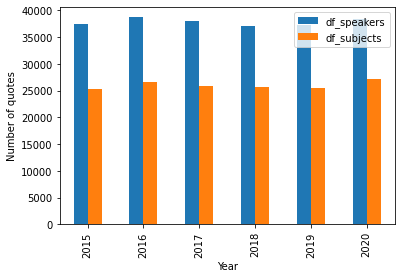

In [ ]:
import numpy as np

X = [2015, 2016, 2017, 2018, 2019, 2020]
Y1 = [len(df.drop_duplicates(subset="quoteID", keep="first")) \
      for df in dfs_speakers]
Y2 = [len(df.drop_duplicates(subset="quoteID", keep="first")) \
      for df in dfs_subjects]

df = pd.DataFrame(np.c_[Y1, Y2], index=X)
ax = df.plot(kind="bar", xlabel="Year", ylabel = "Number of quotes")
ax.legend(["df_speakers", "df_subjects"])

We still have a good number of quotes available. One can also remark that there are less remaining quotes for the subject dataset. This is probably due to fact that in the subject column there are a lot of one word names which are harder to identify. 

But as we lost half of the quotes we should check if this changed our data distribution. Alsoto improve the number of quotes we could think of an algorithm to identify the individuals which which are referred to with their first name only.

#### Merging issues

We remark that we have issues mostly with the subjects but also with the speakers which names are only one word long. Sometimes the subject is misidentified. Indeed you can't identify someone with his first name only. 

For example Hillary Clinton does not have "Hillary" in her aliases. And the only "Hillary" alias refers to Hillary Scott. Hence the alias "Hillary" is not a duplicate and not dropped. If we have a look at the following table we see that the Hillary subject is sometimes misidentified as Hillary Scott because of course President Barack Obama is definitely not speaking about Hillary Scott.

In [ ]:
dfs_subjects[0][dfs_subjects[0]["subject"] == "Hillary"]

,quoteID,subject,speaker,aliases,label,occupation,gender
3952,2015-08-05-029810,Hillary,Maggie Gallagher,Hillary,Hillary Scott,pornographic actor,female
3953,2015-03-07-040570,Hillary,President Barack Obama,Hillary,Hillary Scott,pornographic actor,female
3954,2015-02-04-003637,Hillary,Bill Kristol,Hillary,Hillary Scott,pornographic actor,female
3955,2015-12-29-086905,Hillary,Jo Ellen Litz,Hillary,Hillary Scott,pornographic actor,female
3956,2015-04-13-058729,Hillary,Reince Priebus,Hillary,Hillary Scott,pornographic actor,female
...,...,...,...,...,...,...,...
4109,2015-10-19-029535,Hillary,Michael Dukakis,Hillary,Hillary Scott,pornographic actor,female
4110,2015-09-01-047159,Hillary,Richard Manning,Hillary,Hillary Scott,pornographic actor,female
4111,2015-09-25-099357,Hillary,Steve Elmendorf,Hillary,Hillary Scott,pornographic actor,female
4112,2015-07-26-022487,Hillary,Donald Trump,Hillary,Hillary Scott,pornographic actor,female
